In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Example: Benford's Law

In [3]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)
benford_model

array([ 0.30103   ,  0.17609126,  0.12493874,  0.09691001,  0.07918125,
        0.06694679,  0.05799195,  0.05115252,  0.04575749])

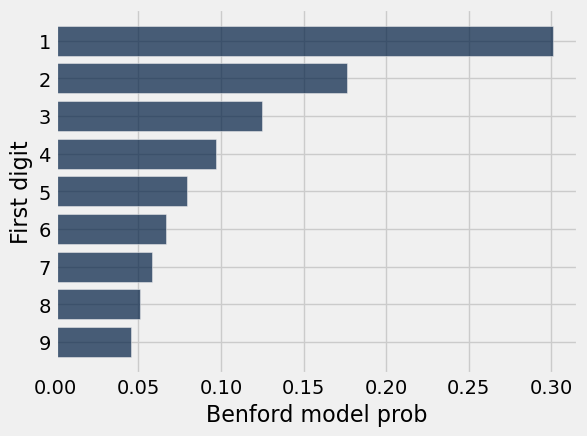

In [4]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford model prob', benford_model)
benford.barh('First digit')

In [5]:
# You don't have to understand how this function works, 
# since it uses Python features from beyond Data 8.
def first_digit(num):
    return int(str(num)[0])

In [7]:
type(first_digit(32))

int

In [8]:
first_digit(17719087)

1

In [10]:
# County populations from the census data
counties = Table.read_table('data/counties.csv')
counties = counties.where('SUMLEV', 50).select(5,6,9).relabeled(0,'State').relabeled(1,'County').relabeled(2,'Population')
counties.show(20)

State,County,Population
Alabama,Autauga County,54684
Alabama,Baldwin County,183216
Alabama,Barbour County,27336
Alabama,Bibb County,22879
Alabama,Blount County,57344
Alabama,Bullock County,10886
Alabama,Butler County,20945
Alabama,Calhoun County,118443
Alabama,Chambers County,34111
Alabama,Cherokee County,25968


In [12]:
first_digits = counties.apply(first_digit, 'Population')
counties = counties.with_column('First digit', first_digits)
counties.show(10)

State,County,Population,First digit
Alabama,Autauga County,54684,5
Alabama,Baldwin County,183216,1
Alabama,Barbour County,27336,2
Alabama,Bibb County,22879,2
Alabama,Blount County,57344,5
Alabama,Bullock County,10886,1
Alabama,Butler County,20945,2
Alabama,Calhoun County,118443,1
Alabama,Chambers County,34111,3
Alabama,Cherokee County,25968,2


In [13]:
num_counties = counties.num_rows

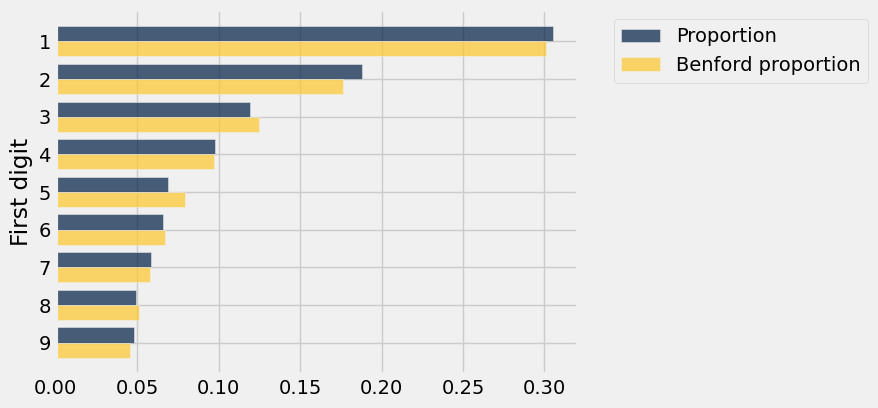

In [14]:
by_digit = counties.group('First digit')
proportions = by_digit.column('count')/num_counties
by_digit = by_digit.with_columns(
    'Proportion', proportions,
    'Benford proportion', benford_model
)
by_digit.drop('count').barh('First digit')

Null hypothesis: Similarities in our Counties proportion and Benford's model are not due to chance

Alternative hypothesis: Similarities in our Counties' propoportion and Benford's model are  due to chance.

Test statistic: TVD

Fill in the blank with "Bigger" or "Smaller":

Smaller values of the test statistic favor the alternative

In [15]:
proportions

array([ 0.30521961,  0.18777849,  0.11935073,  0.09770847,  0.06906429,
        0.06556334,  0.05824316,  0.04901337,  0.04805856])

In [16]:
benford_model

array([ 0.30103   ,  0.17609126,  0.12493874,  0.09691001,  0.07918125,
        0.06694679,  0.05799195,  0.05115252,  0.04575749])

In [17]:
abs(proportions - benford_model)

array([ 0.00418961,  0.01168723,  0.005588  ,  0.00079845,  0.01011696,
        0.00138345,  0.00025121,  0.00213916,  0.00230107])

In [19]:
sum(abs(proportions - benford_model))/2

0.019227569718005828

In [20]:
observed_tvd = sum(abs(proportions - benford_model))/2
observed_tvd

0.019227569718005828

In [21]:
sample_proportions(num_counties, benford_model)
# num_counties = num rows of original data set
# population = all US counties, states only, not territories
# simulate a population matching the original size of our data set, under the null
# our similarities/differences in county data and benford model is not due to chance
# should be similar, in other words

array([ 0.30903883,  0.1744112 ,  0.11807766,  0.09420751,  0.07861235,
        0.07161044,  0.06047104,  0.04774029,  0.04583068])

In [22]:
simulated_frequencies = sample_proportions(num_counties, benford_model)
tvd = sum(abs(simulated_frequencies - benford_model))/2
tvd

0.018668062702884135

In [23]:
def simulate_county_first_digits():
    simulated_frequencies = sample_proportions(num_counties, benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [24]:
simulated_tvds = make_array()

for i in np.arange(10000):
    simulated_tvds = np.append(simulated_tvds, simulate_county_first_digits())

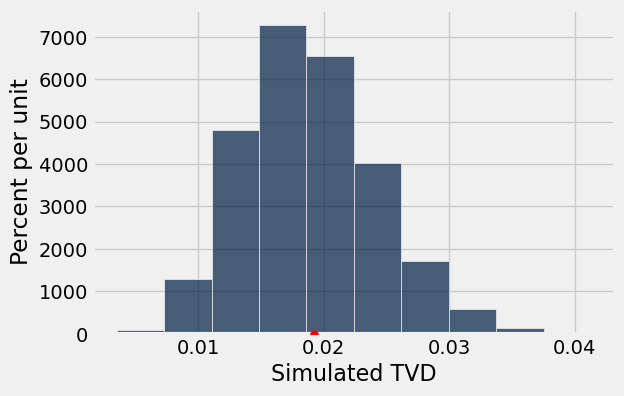

In [27]:
Table().with_column('Simulated TVD', simulated_tvds).hist(0)
plots.scatter(observed_tvd, 0, color='red', s=30, zorder=3)

#small values of tvd support null (left)
# bigger values of tvd support alternative (right)

# p-value is the proportion of simulated values that are equal to observed value (0.019....)
# and further in direction of alternative (right)

In [26]:
np.count_nonzero(simulated_tvds >= observed_tvd) / 10000
# p-value
# 44.63% > 5%
# we fail to reject our null hypothesis 
# 44.63% of the time, we were able to simulate values (under the null) equal to 
# observed value (0.019....)
# and further in direction of alternative (right)

# conclusion: we fail to reject the null (simpler terms: null hypothesis might be good)
# in other terms, we lean toward the null

0.4463

Are the data consistent with the null hypothesis?

## Example: sleep survey

In [ ]:
survey = Table.read_table('data/sleep_survey.csv')
survey

In [ ]:
def simplify(sleep_position):
    if sleep_position == 'On your left side' or sleep_position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'
    
survey = survey.with_column(
    'position',
    survey.apply(simplify, 'Sleep position')
).select('position', 'Hours of sleep')

survey

In [ ]:
survey.group('position', np.average)

Null hypothesis: Any differences between average hours of sleep between back/stomach sleepers or side sleepers is due to chance.


Alternative hypothesis: One of the groups get more sleep on average

Test statistic: Absolute value of (Average hours of sleep for side - Average hours of sleep for back/stomach)

Fill in the blank with "Bigger" or "Smaller":

Larger values of the test statistic favor the alternative

In [ ]:
def compute_test_statistic(tbl):
    grouped = tbl.group('position', np.average)
    avgs = grouped.column('Hours of sleep average')
    #print(avgs)
    return abs(avgs.item(1) - avgs.item(0))

In [ ]:
obs_test_stat = compute_test_statistic(survey)
obs_test_stat

In [ ]:
random_labels = survey.sample(with_replacement=False).column('position')

In [ ]:
def simulate_under_null():
    random_labels = survey.sample(with_replacement=False).column('position')
    relabeled_tbl = survey.with_column('position', random_labels)
    return compute_test_statistic(relabeled_tbl)


In [ ]:
simulated_diffs = make_array()
for i in np.arange(1000):
    null_stat = simulate_under_null()
    simulated_diffs = np.append(simulated_diffs, null_stat)

In [ ]:
Table().with_column('Simulated difference', simulated_diffs).hist(0)

In [ ]:
obs_test_stat

In [ ]:
np.mean(simulated_diffs <= obs_test_stat)

In [ ]:
(len(simulated_diffs <= obs_test_stat ))/1000

Are the data consistent with the null hypothesis?